## Required Libraries


In [1]:
pip install scipy numpy matplotlib umap-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=0a7b991b2e4127e31018ed381dcb50092433049b3e567a474f3b662d58226e15
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=e161e84bef1a2b167a717633ae804b3c2373648bb46a9df1d10fec3ae18decee
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [2]:
# May take a minute
import numpy as np
import scipy
import matplotlib.pyplot as plt
import umap
import pandas as pd

## File Loading
To access the data choose one option:

1. Download the file and upload it to google colab via the folder menu.

2. Copy the file to your google drive, and mount google drive as I demonstrate.

In [3]:
# Connect this notebook to google drive (should pop up and request access)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
# Load data from npz file
inputDataset = np.load('/content/drive/MyDrive/Processed_Bird/B119-Processed_5ms-Neural_30-Bouts.npz',allow_pickle=True)

### This data contains four numpy arrays:

  - **Vocal_data**: A 1D array of length 20, where each element is an array containing raw microphone data from one bout of singing


  - **Neural_data**: Neural_Data[N] will access a raster plot of firing rate across 837 neurons at 5ms resolution for the neural data corresponding to the Nth bout of singing


  - **Vocal_time**: Single array which contains 30 kHz time points for the microphone data (all bouts are exactly the same length)


  - **Neural_time**: Single array which contains 200 Hz time points for neural data (all bouts are exactly the same length)

In [53]:
Vocal_data = inputDataset['vocal_data']
Neural_data = inputDataset['neural_data']
Vocal_time = inputDataset['vocal_time']
Neural_time = inputDataset['neural_time']

## Microphone Data

Let's explore what these bouts actually sound like!

In [54]:
# Play sound from an example bout
from IPython.display import Audio

example_bout = 7
bout_audio = Vocal_data[example_bout - 1] # Remember python indexing starts at zero!
Audio(bout_audio, rate=30000) # this whole dateset 30kHz

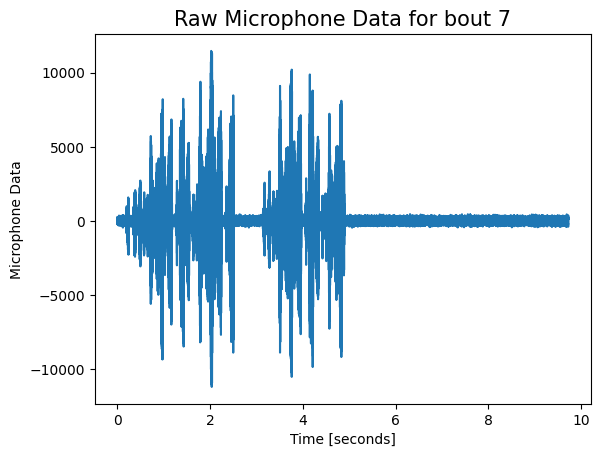

In [55]:
# We can plot this microphone data
plt.plot(Vocal_time,bout_audio)
plt.title(f'Raw Microphone Data for bout {example_bout}',fontsize = 15)
plt.xlabel('Time [seconds]',fontsize = 10)
plt.ylabel('Microphone Data',fontsize = 10)
plt.show()

In [56]:
# A spectrogram is a more interpretable way to plot audio

# Parameters for https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
FS = 30000
NFFT = 512
noverlap = 450
logAdditive = 2

f, tSpec, Sxx = scipy.signal.spectrogram(bout_audio, FS,nfft = NFFT,noverlap = noverlap,nperseg = NFFT)
logSpec = np.log(Sxx + logAdditive)



Try some variations on this spectrogram code:
  - How would you increase time resolution?
  - Can you add another processing step where you set any elements in logSpec below a threshold to zero
  - You can also display logSpec with plt.imshow instead of plt.pcolormesh

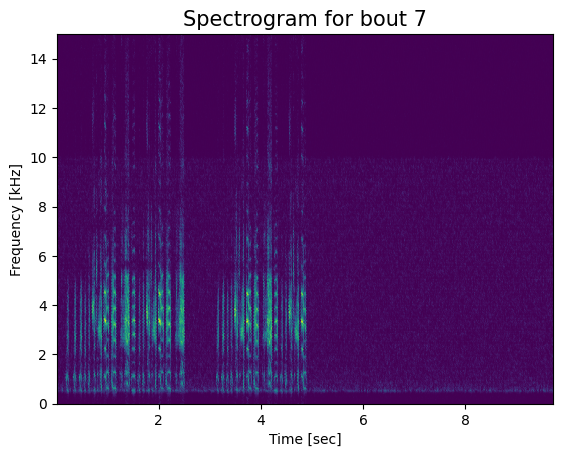

In [57]:
# Displaying the spectrogram
plt.pcolormesh(tSpec, f/1000, logSpec, shading='gouraud')
plt.ylabel('Frequency [kHz]',fontsize = 10)
plt.xlabel('Time [sec]',fontsize = 10)
plt.title(f'Spectrogram for bout {example_bout}',fontsize = 15)
plt.show()


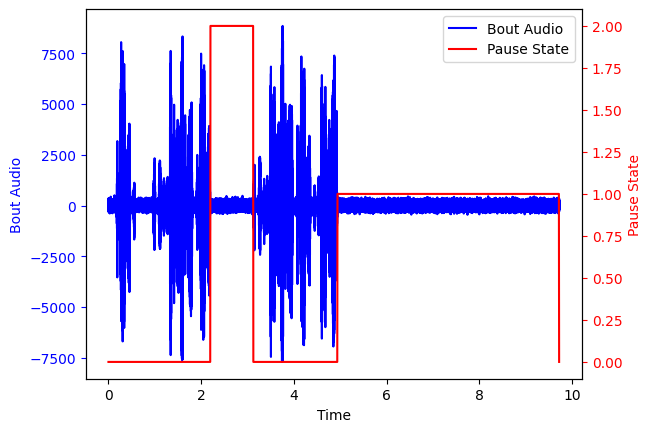

In [78]:
# Special def of pause and silence

def find_zero_subarrays(arr, min_length,timeArr = []):

    if len(timeArr) == 0:
      timeArr = np.arange(len(arr))

    timeStep = timeArr[1] - timeArr[0]
    # print(timeStep)
    #min length ms --> index
    min_length = int(min_length/1000/timeStep)
    # print(min_length)

    zero_segments = []
    start = None

    for i in range(len(arr)):
        if arr[i] == 0:
            if start is None:
                start = i
        else:
            if start is not None:
                end = i - 1
                if end - start + 1 >= min_length:
                  zero_segments.append((timeArr[start], timeArr[end]))
                start = None

    # Check if the last segment ends with a zero
    if start is not None:
        end = len(arr) - 1
        if end - start + 1 >= min_length:
            zero_segments.append((timeArr[start], timeArr[end]))



    return zero_segments


# Define segmentation
def breakSegmentation(audioData,timeData):

  # Create Spectrograms
  FS = 30000
  NFFT = 512
  noverlap = 450
  logAdditive = 2

  f, tSpec, Sxx = scipy.signal.spectrogram(bout_audio, FS,nfft = NFFT,noverlap = noverlap,nperseg = NFFT)
  logSpec = np.log(Sxx + logAdditive)

  # Threshold and column sums
  columnSums = np.sum(logSpec,axis = 0)

  threshold = 300
  diagnosticArr  = columnSums.copy()
  diagnosticArr[diagnosticArr < threshold] = 0
  diagnosticArr[diagnosticArr > threshold]  = 100

  # Segments
  segments = find_zero_subarrays(diagnosticArr, 500,timeArr = tSpec)
  # print(segments)
  # plt.plot(tSpec,columnSums)
  # plt.plot(tSpec,diagnosticArr)

  return segments


def neuralSegmentArray(neuralData,neuralTime,inputSegment):
  startTime = neuralTime[0]
  endTime = neuralTime[-1]

  pause_state = np.zeros_like(neuralTime)
  # print(pause_state)
  for arr in inputSegment:
    segStart,segEnd = arr
    relInd = np.where(np.logical_and(neuralTime > segStart, neuralTime < segEnd))[0]
    if abs(segStart - startTime) < .5 or abs(segEnd - endTime) < .5:
      pause_state[relInd] = 1
    else:
      pause_state[relInd]  = 2

    # 0- activity, 1 - background silence, 2- intermediate pause

  return pause_state



example_bout = 12
bout_audio = Vocal_data[example_bout - 1] # Remember python indexing starts at zero!
segments = breakSegmentation(bout_audio,Vocal_time)

exampleSpkData = Neural_data[example_bout - 1]
pause_state = neuralSegmentArray(exampleSpkData,Neural_time,segments)
# plt.plot(Vocal_time,bout_audio)
# plt.plot(Neural_time,pause_state)



# Assuming you have data in the arrays Vocal_time, bout_audio, Neural_time, and pause_state

# Create the first plot and axis (left y-axis)
fig, ax1 = plt.subplots()

# Plot the first set of data on the left y-axis
ax1.plot(Vocal_time, bout_audio, 'b', label='Bout Audio')
ax1.set_xlabel('Time')
ax1.set_ylabel('Bout Audio', color='b')
ax1.tick_params('y', colors='b')

# Create the second plot and axis (right y-axis)
ax2 = ax1.twinx()

# Plot the second set of data on the right y-axis
ax2.plot(Neural_time, pause_state, 'r', label='Pause State')
ax2.set_ylabel('Pause State', color='r')
ax2.tick_params('y', colors='r')

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

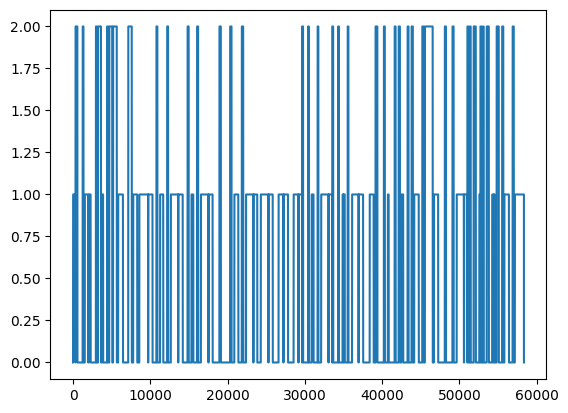

In [59]:
totalNeural = None
totalPause = None
for loopBout in range(1,31):

  bout_audio = Vocal_data[loopBout - 1] # Remember python indexing starts at zero!
  segments = breakSegmentation(bout_audio,Vocal_time)

  exampleSpkData = Neural_data[loopBout - 1]
  pause_state = neuralSegmentArray(exampleSpkData,Neural_time,segments)

  try:
    totalNeural = np.hstack((totalNeural,exampleSpkData))
    totalPause = np.hstack((totalPause,pause_state))
  except:
    totalNeural = exampleSpkData
    totalPause = pause_state

# plt.figure(figsize = (30,20))
plt.plot(totalPause)
plt.show()
# print(pause_state)

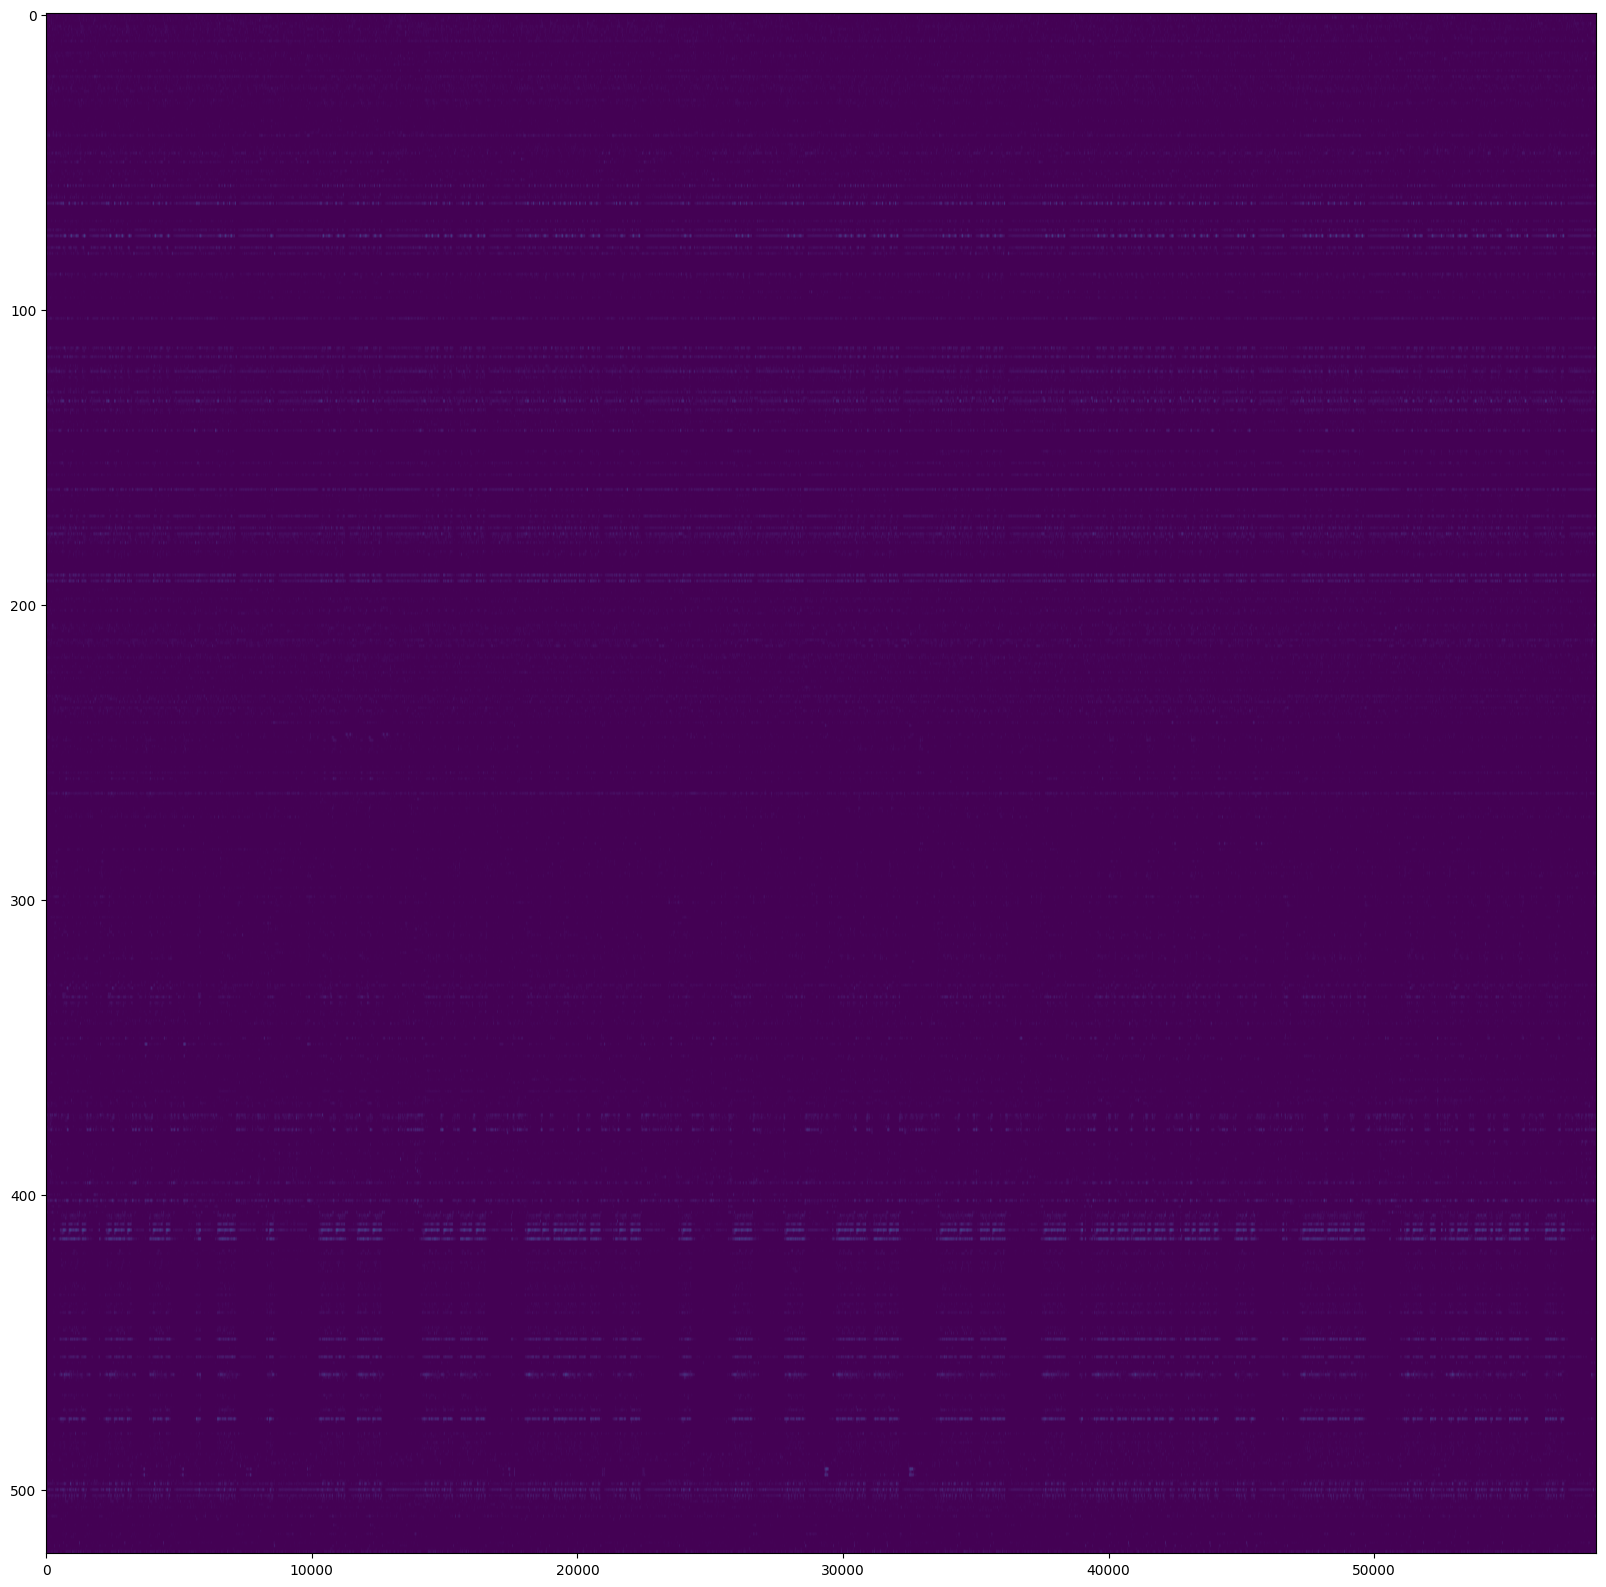

In [60]:
# You can also plot it with imshow but some of the spikes get drowned out by a background
plt.figure(figsize = (20,20))
plt.imshow(totalNeural,aspect = 'auto')

plt.show()

Try plotting a subset of the data in time or neuron to see finer detail

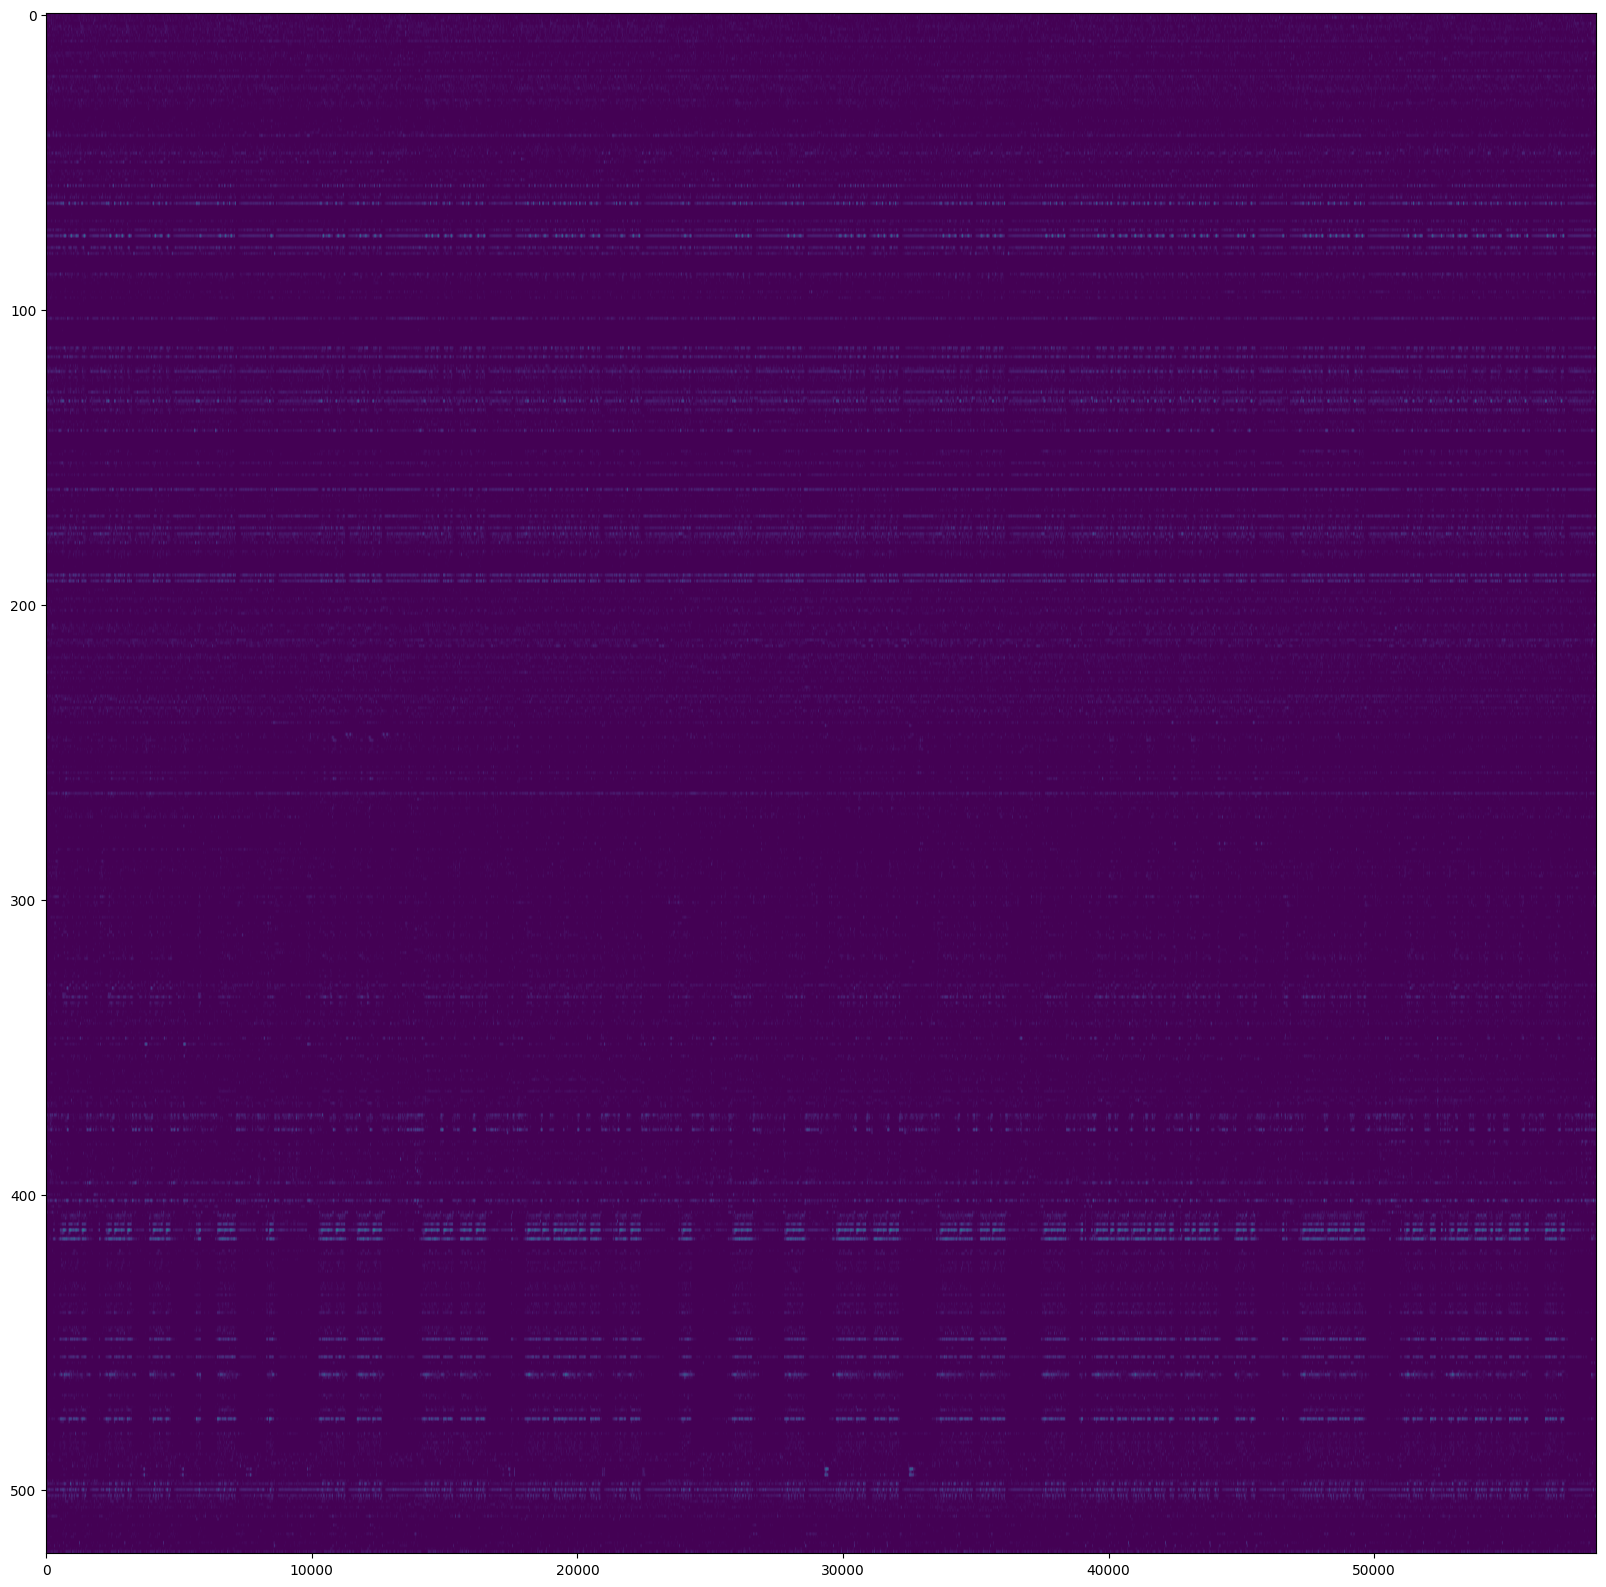

In [61]:
# Smooth data with gaussian kernel

def apply_gaussian_kernel(data, time_const = 10):

    result = np.zeros_like(data)
    for i in range(data.shape[0]):
        result[i] = scipy.ndimage.gaussian_filter1d(data[i], time_const)

    return result

smoothed_spiking = apply_gaussian_kernel(totalNeural,time_const = 2) # blur array
plt.figure(figsize = (20,20))
plt.imshow(smoothed_spiking,aspect = 'auto')
plt.show()

Now we slice the data (play with the window and step size for varied results)

In [62]:
# To do umap we are going to take slices of this data

def get_matrix_slices(matrix, window_size, step_size):
    matrix_shape = matrix.shape
    num_slices = (matrix_shape[1] - window_size) // step_size + 1
    slices = np.zeros((matrix_shape[0], window_size, num_slices))
    slice_times = np.zeros((num_slices))

    for i in range(num_slices):
        start = i * step_size
        end = start + window_size
        slices[:, :, i] = matrix[:, start:end]
        slice_times[i] = (start + end)/2

    return slices,slice_times

window_size = 20 # should adjust with binning (5ms --> 20 100ms)
step_size = 1
slices, slice_times = get_matrix_slices(smoothed_spiking,window_size, step_size)
print(slices.shape)

(522, 20, 58331)


UMAP requires a specific input format where the array is 2d with (numInputs, inputSize) as the dimensions. This is just some numpy algebra!

In [63]:
# Some algebra to prepare for umap

# Turn each slice into a 1D vector
original_shape = slices.shape
flattened_matrix = slices.reshape(original_shape[0] * original_shape[1], original_shape[2]).T

# calculate start times in seconds CHNAGE
roundingFactor = 150
print(slice_times)

relPause = totalPause[slice_times.astype(int)]

relTime = slice_times*roundingFactor/FS
print(relPause.shape)
print(relTime.shape)

[1.0000e+01 1.1000e+01 1.2000e+01 ... 5.8338e+04 5.8339e+04 5.8340e+04]
(58331,)
(58331,)


In [64]:
# Load the umap library, and transform the data
fit = umap.UMAP() # Read this and change the input options (metric, n neighbors, etc): https://umap-learn.readthedocs.io/en/latest/parameters.html
spk_emb = fit.fit_transform(flattened_matrix)

In [65]:
spk_emb.shape

(58331, 2)

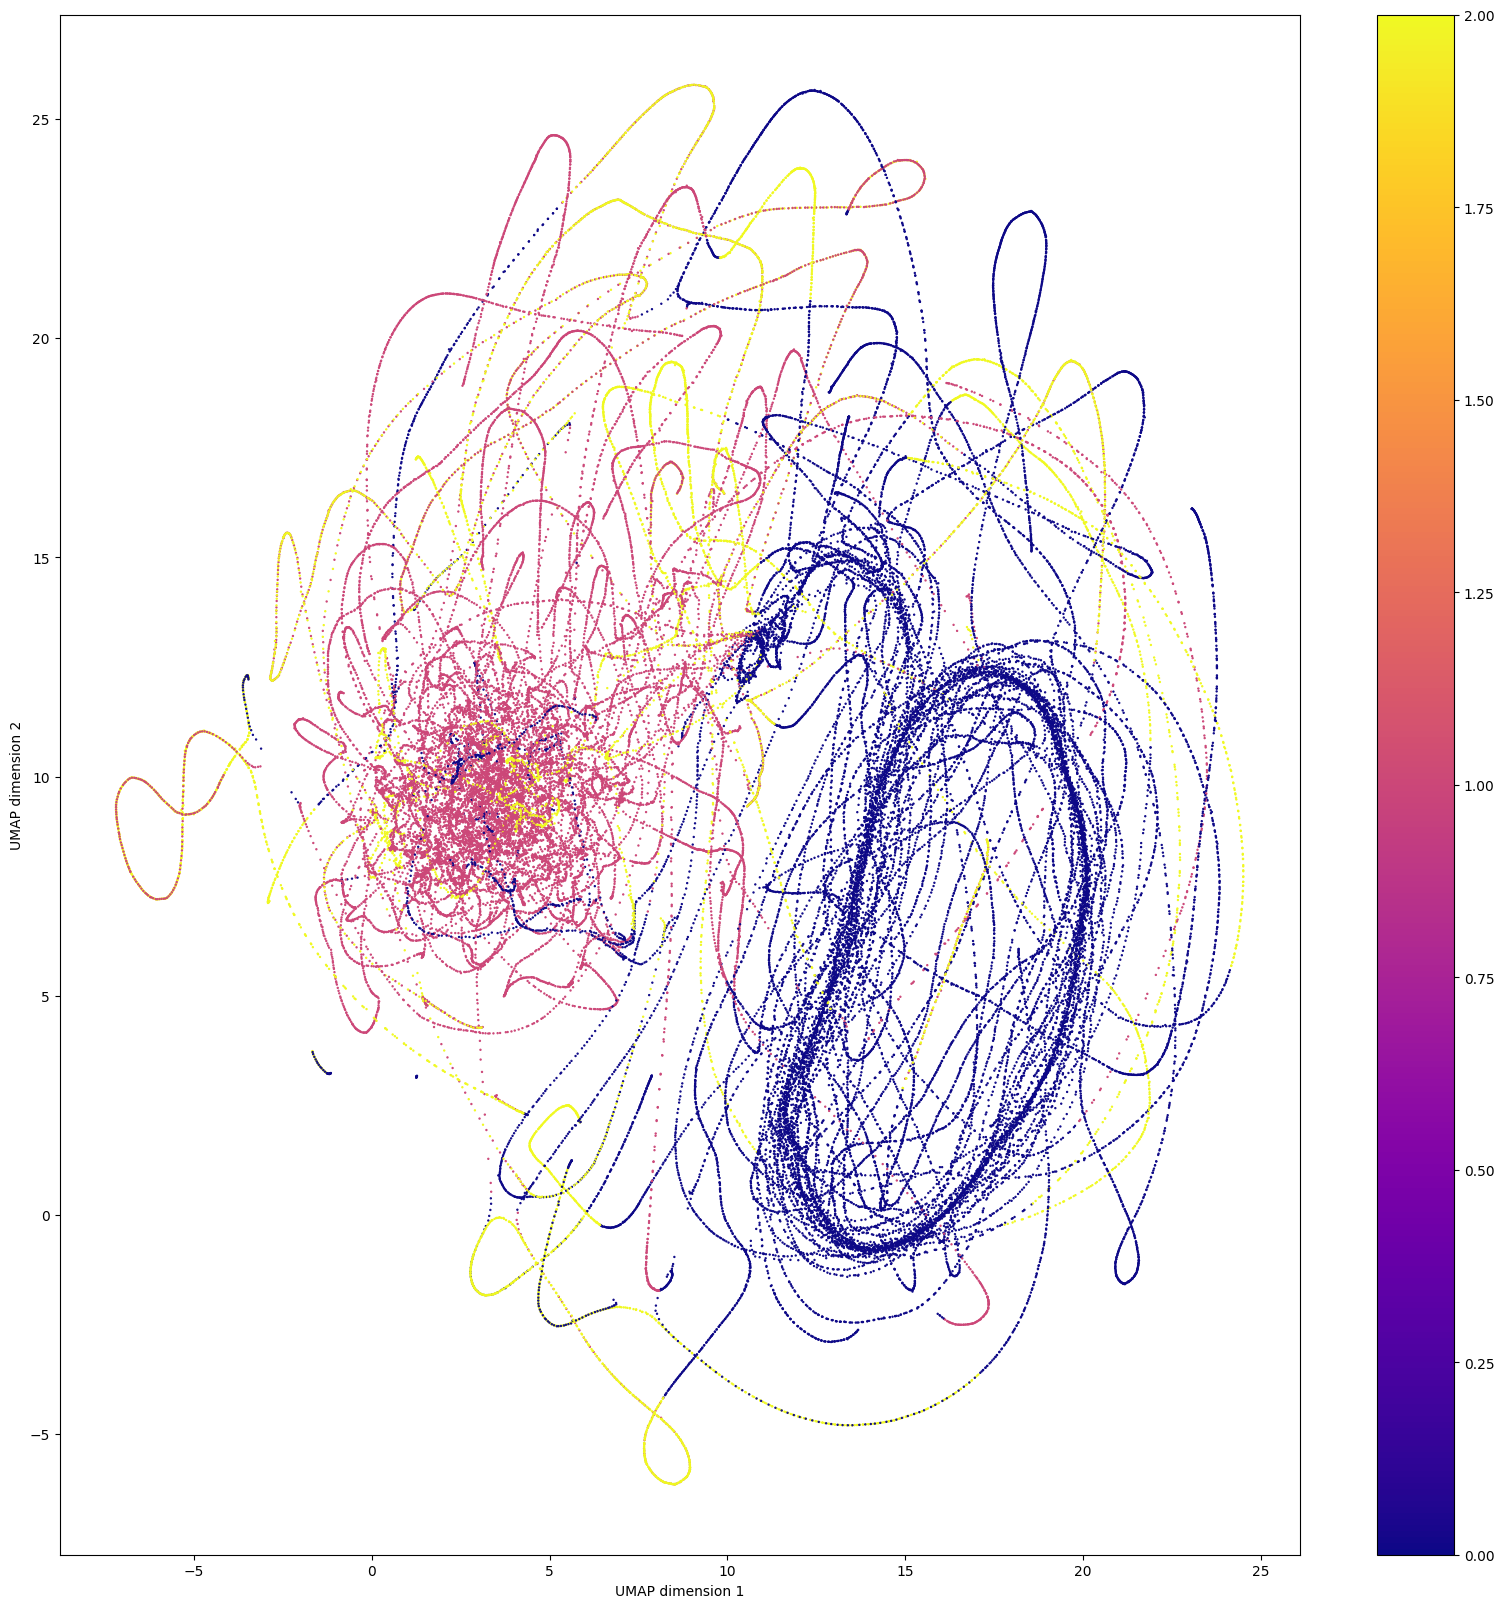

In [66]:
# Plot data in UMAP space
plt.figure(figsize = (20,20))
plt.scatter(spk_emb[:,0],spk_emb[:,1],c = relPause,s = .5,cmap='plasma')
# plt.title('Blurred Spiking UMAP - Colorized by Pause')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
cbar = plt.colorbar()
# cbar.set_label('Pause State')
plt.show()

# Non UMAP analysis

In [67]:
print(totalNeural.shape)
print(totalPause.shape)

(522, 58350)
(58350,)


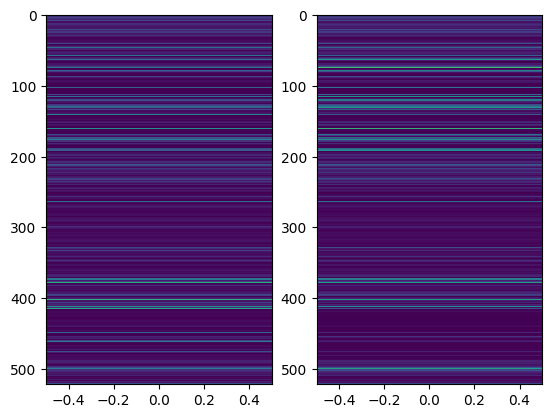

In [80]:
intermediateStates = np.where(totalPause == 2)[0]
exteriorStates = np.where(totalPause == 1)[0]

aveInt = np.mean(totalNeural[:,intermediateStates],axis = 1)[:, np.newaxis]
aveExt = np.mean(totalNeural[:,exteriorStates],axis = 1)[:, np.newaxis]

plt.subplot(1,2,1)
plt.imshow(aveInt,aspect = 'auto')
plt.subplot(1,2,2)
plt.imshow(aveExt,aspect = 'auto')